Este jupyter notebook é uma versão interativa do arquivo OnionSkin.py.

# Introdução

A simulação computacional de modelos matemáticos tem sido utilizada em neurociências e auxiliado o estudo e a compreensão de mecanismos envolvidos no funcionamento do sistema nervoso, que podem ser difíceis por meio exclusivo da experimentação. Especificamente, para o sistema neuromuscular humano, modelos matemáticos multiescala (que representam mecanismos operando em níveis celulares e/ou moleculares até elementos macroscópicos, como os processos de geração e controle da força muscular) têm possibilitado estudos sobre os comportamentos dinâmicos de redes de motoneurônios alfa (MNs) controlando a geração de força muscular [1-5]. Estes estudos fornecem subsídios conceituais para uma maior compreensão de aspectos neurofisiológicos do controle motor, como, por exemplo: i) os papéis do recrutamento e da modulação da frequência de disparos de potenciais de ação (PAs) na relação força-EMG [1]; ii) a atuação de vias de realimentação sensorial no controle da força muscular [2]; iii) o efeito de condições patológicas no controle reflexo da força [3]; e iv) o efeito de entradas neuromodulatórias na atividade de MNs individuais e na variabilidade da força muscular [4]. Além destas aplicações científicas importantes, modelos computacionais do sistema nervoso e muscular podem ser utilizados como ferramentas didáticas em cursos de Neurociências e Controle Motor [5].

# Objetivos

Neste estudo, o objetivo é o desenvolvimento de um modelo multiescala simplificado do sistema neuromuscular que seja reproduzível. O modelo foi concebido de forma a possuir plausibilidade biológica e eficiência computacional e para a implementação computacional dos modelos foram adotadas plataformas flexíveis e reconhecidas pela comunidade científica da área de Neurociências.Neste trabalho é apresentado um modelo computacional de um núcleo motor (composto por três motoneurônios alfa) e as respectivas unidades musculares. O modelo neuromuscular é constituído por unidades motoras dos tipos S, FR e FF, que foram implementadas computacionalmente utilizando a linguagem de programação Python e as bibliotecas do simulador NEURON.

# Métodos

O modelo foi implementado em linguagem de programação Python (versão 2.7.13), que é uma linguagem livre, de fácil entendimento [6] e que vem sendo utilizada e difundida pela comunidade científica de Neurociência Computacional [7]. Os elementos neuronais foram implementados utilizando as bibliotecas do simulador NEURON [8] para a linguagem Python. A rede de MNs foi implementada utilizando o NetPyNE [9].

O modelo neuromuscular desenvolvido é composto por apenas três MNs (modelo simplificado) e as fibras musculares por eles inervadas. As fibras musculares pertencentes a uma determinada unidade motora são referidas como unidades musculares (UMs). Os modelos individuais dos MNs e das UMs serão descritos abaixo.

## Modelo de MN alpha
Foram representados modelos de MNs dos tipos S (*slow*, que inerva fibras musculares lentas e resistentes à fadiga), FR (*fast fatigue resistant*, fibras rápidas e resistentes à fadiga) e FF (*fast fatigable*, fibras rápidas e fatigáveis). Estes modelos foram baseados na proposta de Cisi e Kohn [5], em que a morfologia dos MNs é sintetizada em dois compartimentos acoplados por uma condutância. Um compartimento representa a árvore dendrítica, que neste estudo foi suposta passiva, e o outro compartimento representa o corpo celular (ou soma). O circuito elétrico equivalente dos modelos está ilustrado na Figura 1. As condutâncias ativas somáticas são responsáveis pelo decurso temporal do PA e da AHP (*after hyperpolarization*). Estas condutâncias (Na+, K+, persistente de Na+ e lenta de K+) foram parametrizadas e validadas em um estudo anterior do nosso laboratório [10]. Os parâmetros geométricos e eletrotônicos (Tabela 1) foram baseados em estudos experimentais anteriores com MNs de gatos anestesiados [11-13].

### Código: compilando os arquivos do modelo

Este passo é importante para que os arquivos do tipo `.mod`, que descrevem os mecanismos celulares e a corrente injetada, sejam compilados e entendidos pelo simulador.

In [1]:
!nrnivmodl MODfiles

/work/reproducible/dev
MODfiles/Force.mod MODfiles/IClampX.mod MODfiles/XClamp.mod MODfiles/caL.mod MODfiles/force_syn.mod MODfiles/napp.mod MODfiles/peakcount.mod MODfiles/refrac.mod
Force.mod IClampX.mod XClamp.mod caL.mod force_syn.mod napp.mod peakcount.mod refrac.mod
"/work/nrn-7.4/share/nrn/libtool" --tag=CC --mode=compile mpicc -DHAVE_CONFIG_H  -I. -I.. -I"/work/nrn-7.4/include/nrn" -I"/work/nrn-7.4/x86_64/lib"      -O3 -c -o mod_func.lo mod_func.c
libtool: compile:  mpicc -DHAVE_CONFIG_H -I. -I.. -I/work/nrn-7.4/include/nrn -I/work/nrn-7.4/x86_64/lib -O3 -c mod_func.c  -fPIC -DPIC -o .libs/mod_func.o
libtool: compile:  mpicc -DHAVE_CONFIG_H -I. -I.. -I/work/nrn-7.4/include/nrn -I/work/nrn-7.4/x86_64/lib -O3 -c mod_func.c -o mod_func.o >/dev/null 2>&1
"/work/nrn-7.4/share/nrn/libtool" --tag=CC --mode=link mpicc -module  -O3    -o libnrnmech.la -rpath "/work/nrn-7.4/x86_64/lib"  Force.lo IClampX.lo XClamp.lo caL.lo force_syn.lo napp.lo peakcount.lo refrac.lo mod_func.lo  -L"/work

### Início do código em Python

Primeiro, importam-se as bibiotecas e definem-se variáveis para facilitar o uso das bibliotecas:

In [2]:
from netpyne import sim, specs
import numpy as np
from matplotlib import pyplot as plt
import nerlabmodel as ner

netParams = specs.NetParams()
simConfig = specs.SimConfig()


*******
  Note: NeuroML import failed; import/export functions for NeuroML will not be available. 
  Install the pyNeuroML & libNeuroML Python packages: https://www.neuroml.org/getneuroml
*******



Em seguida, configura-se a população de três neurônios, no caso, população `Pop1` com células do tipo medular (`MED`) e de modelo com condutânica de sódio (`NAPP`), sendo estes identificadores criados neste momento.

In [3]:
netParams.popParams['Pop1'] = {'cellType': 'MED',
                               'cellModel': 'NAPP',
                               'numCells': 3}

Abaixo, são definidas e configuradas as propriedades dos neurônios da população. A princípio todos os neurônios terão as mesmas propriedades.

In [4]:
cellRule = {'conds': {'cellType': 'MED', 'cellModel': 'NAPP'},
            'secs': {'soma': {'geom': {'diam': 80, 'L': 80, 'Ra': 70,
                                       'cm': 1, 'nseg': 1},
                              'mechs': {'napp': {'gnabar': 0.05,
                                                 'gnapbar': 0.00052,
                                                 'gkfbar': 0.0028,
                                                 'gksbar': 0.018,
                                                 'mact': 13.0,
                                                 'rinact': 0.025,
                                                 'el': 0.0,
                                                 'vtraub': 0.0,
                                                 'gl': 1/1100.0}},
                              'ions': {'na': {'e': 120},
                                       'k': {'e': -10}},
                              'vinit': 0},
                     'dend': {'geom': {'diam': 52.0, 'L': 6150.0, 'Ra': 70.0,
                                       'cm': 1, 'nseg': 1},
                              'topol': {'parentSec': 'soma',
                                        'parentX': 0,
                                        'childX': 1},
                              'mechs': {'pas': {'g': 1/12550.0, 'e': 0.0}},
#                              'ions': {'caL': {'e': 140}},
                              'vinit': 0}}}
netParams.cellParams['HHNapp'] = cellRule

Em seguida são descritas as características a corrente que será injetada nos neurônios, uma corrente triangular com 5000ms de duração e amplitude máxima de 22 nA. Depois das propriedades do estímulo, é descrita a conexão do estímulo com a população de neurônios, sendo a corrente injetada no compartimento `soma`.

In [5]:
current_amplitude = 22.
current_duration = 5000.

In [6]:
netParams.stimSourceParams['Istep'] = {'type': 'IClampX',
                                       'signal_type': 2, #triang
                                       'delay': 20,
                                       'risedur': current_duration/2.,
                                       'falldur': current_duration/2.,
                                       'amp': current_amplitude
                                       }
netParams.stimTargetParams['Istep->Pop1'] = {'source': 'Istep',
                                             'conds': {'cellType': 'MED',
                                                       'cellModel': 'NAPP'},
                                             'sec': 'soma',
                                             'loc': 0.5}

Abaixo, definem-se a duração da simulação, o passo de integração e outras variáveis necessárias para o funcionamento do simulador. Logo após, são selecionados os dados provenientes da simulação que se deseja salvar, no caso, o decurso temporal do potencial de membrana de todos os neurônios (`v_soma`).

In [7]:
simConfig.duration = current_duration + 220.
simConfig.dt = 0.025
simConfig.seeds = {'conn': 1, 'stim': 1, 'loc': 1}
simConfig.createNEURONObj = True
simConfig.createPyStruct = True
simConfig.verbose = False
simConfig.recordCells = ['all']
simConfig.recordTraces = {'v_soma': {'sec':'soma', 'loc': 0.5, 'var': 'v'}}
simConfig.recordStim = True
simConfig.recordStep = simConfig.dt

O comando a seguir cria todos os objetos descritos acima e armazena referências a eles em variáveis.

In [8]:
(pops, cells, conns, stims, simData) = sim.create(netParams=netParams, simConfig=simConfig, output=True)


Creating network of 1 cell populations on 1 hosts...
  Number of cells on node 0: 3 
  Done; cell creation time = 0.01 s.
Making connections...
  Number of connections on node 0: 0 
  Done; cell connection time = 0.00 s.
Adding stims...
  Number of stims on node 0: 3 
  Done; cell stims creation time = 0.00 s.
Recording 6 traces of 2 types on node 0


Podemos inspecionar os objetos:

In [9]:
cells

In [10]:
cells[0].secs.dend

{mechs: {pas: {e: 0.0, g: 7.968127490039841e-05}}, hSec: <nrn.Section object at 0x7fcb83295710>, geom: {nseg: 1, diam: 52.0, L: 6150.0, cm: 1, Ra: 70.0}, _repr_mimebundle_: {}, vinit: 0, topol: {childX: 1, parentSec: 'soma', parentX: 0}}

Agora, as propriedades os neurônios serão alteradas para que eles sejam diferentes entre si. As funções `mus`, `mufr` e `muff` alteram os parâmetros do soma e do dendrito de um neurônio tais que este represente um neurônio motor do tipo **S**, **FR** e **FF**, respectivamente. 

In [11]:
mutype = []
for n in range(len(cells)):
    soma = cells[n].secs.soma.hSec
    dend = cells[n].secs.dend.hSec
    if n == 0:
        ner.mus(soma, dend)
        mutype.append('S')
    elif n == 1:
        ner.mufr(soma, dend)
        mutype.append('FR')
    elif n == 2:
        ner.muff(soma, dend)
        mutype.append('FF')

Então, a simulação é feita e os dados adquiridos.

In [12]:
sim.simulate()
sim.analyze()


Running simulation for 5220.0 ms...
  Done; run time = 0.70 s; real-time ratio: 7.42.

Gathering data...
  Done; gather time = 0.06 s.

Analyzing...
  Cells: 3
  Connections: 0 (0.00 per cell)
  Spikes: 196 (12.52 Hz)
  Simulated time: 5.2 s; 1 workers
  Run time: 0.70 s
  Done; saving time = 0.00 s.
  Done; plotting time = 0.00 s


Em seguida são feitas as análises pós-simulação. A partir dos dados gerados pelo simulador são criados os objetos python para manipulação usando a biblioteca `numpy`. São adquiridos o vetor tempo e os potenciais de membrana dos neurônios motorres no tempo.

In [13]:
t = np.array(simData.t.to_python())
v_list = list()
for i in pops['Pop1'].cellGids:
    cell = 'cell_'+str(i)
    v_list.append(np.array(simData['v_soma'][cell].to_python()))
cells_v = np.array(v_list).transpose()

Agora, por meio dos decursos temporais dos potenciais de membrana, os instantes de disparo de potenciais de ação (PA) são identificados. Logo após, estes instantes são utilizados para a geração da força de cada unidade muscular.

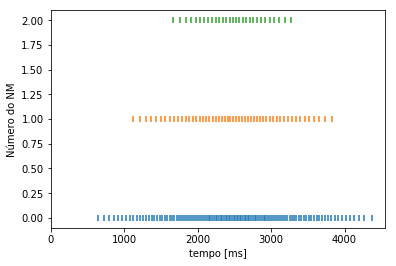

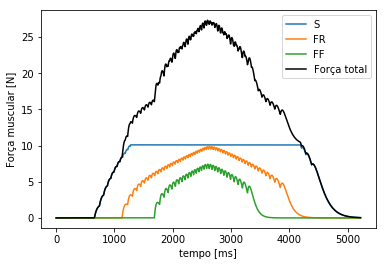

In [14]:
spkt, spkv = ner.getSpikes(t, cells_v, 20, output=True, plotRaster=True, newfigure=True)
force = ner.forceSOF(spkt, t, mutype)

Note o funcionamento do mecanismo de saturação da força, principalmente na unidade muscular do tipo FF. Neste modelo simplificado a saturação é feita limitando o valor máximo da força.
Em seguida são calculadas as frequências instantâneas de disparo de cada neurônio.

In [15]:
ifreq = 1000./np.diff(spkt)
midtimes = spkt[:,1:] - np.diff(spkt)/2.
#midtimes[1,51]=0
#midtimes[2,28]=0

Abaixo, são plotados em um mesmo gráfico a frequência instantânea de cada neurônio motor (circulos coloridos preenchidos), a força muscular total (linha preta) e os instantes de disparo dos potenciais de ação (traços verticais na parte inferior da figura).

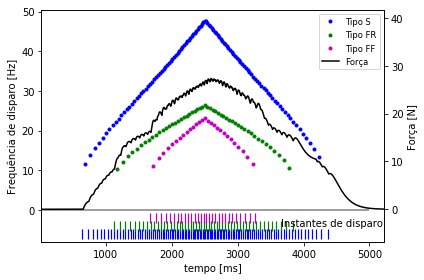

In [16]:
fig,ax = plt.subplots()
#plt.plot(t, force[:,:t.size].transpose(), 'k')
#plt.plot(t, force.sum(axis=0))
#plt.plot(t, force.transpose())
#plt.plot(spkt[:,1:-1].transpose(),ifreq[:,:-1].transpose(),'.')
for cell in range(min(spkt.shape)):
    if cell == 0:
        ax.plot(spkt[cell,:], -6*np.ones(max(spkt.shape)), '|b',
                markeredgewidth=1.2, markersize=10)
        ax.plot(midtimes[cell,:-1].transpose(),ifreq[cell,:-1].transpose(),
                '.b', label='Tipo S')
    elif cell == 1:
        ax.plot(spkt[cell,:], -4*np.ones(max(spkt.shape)), '|g',
                markeredgewidth=1.2, markersize=10)
        ax.plot(midtimes[cell,:-1].transpose(),ifreq[cell,:-1].transpose(),
                '.g',label='Tipo FR')
    elif cell == 2:
        ax.plot(spkt[cell,:], -2*np.ones(max(spkt.shape)), '|m',
                markeredgewidth=1.2, markersize=10)
        ax.plot(midtimes[cell,:-1].transpose(),ifreq[cell,:-1].transpose(),
                '.m',label='Tipo FF')
ax.plot(0,0,'-k', label=u'For\u00e7a')
ax.set_xlim((20,simConfig.duration))#5000))
ax.set_ylim(ymin=-8)
ax.hlines(0,20,5000,'grey')
ax.set_ylabel(u'Frequência de disparo [Hz]')
ax.set_xlabel('tempo [ms]')
ax.legend(fontsize='small', loc='best')
ax.text(simConfig.duration*.7,-4, "Instantes de disparo")#, bbox=dict(facecolor='white'))
ax2 = ax.twinx()
ax2.plot(t,force.sum(axis=0), '-k')
ax2.set_xlim((20,simConfig.duration))#5000))
ax2.set_ylim((-6.8,50/1.2)) #5.0/1.2))
ax2.set_ylabel(u'Força [N]')

fig.tight_layout()
plt.show()


## Princípio do tamanho e geração da força muscular

Na parte inferior do gráfico acima estão indicados os instantes de disparos dos MNs de cada tipo (S em azul, FR em verde e FF em magenta). Os pontos na parte superior do gráfico indicam as frequências instantâneas de disparo dos MNs (mesmo código de cores) e a linha preta contínua representa a força total exercida pelo modelo simplificado de músculo. Nota-se que a unidade motora do tipo S é a primeira a ser recrutada, pois seu MN possui uma menor área celular e, consequentemente, uma maior resistência de entrada. Por outro lado, a unidade motora do tipo FF é a última a ser recrutada, pois o MN possui uma maior área celular e menor resistência de entrada. Além disso, observa-se nos resultados a ordem inversa de derrecrutamento, com a unidade motora de maior limiar (tipo FF) sendo derrecrutada primeiro e a de menor limiar (tipo S) por último.

Do ponto de vista das frequências de disparos de PAs, observa-se que as unidades motoras recrutadas com um menor limiar atingem taxas de disparos maiores em comparação com as unidades motoras de maior limiar, para uma mesma magnitude da corrente de estimulação.

Quanto à geração da força muscular, nota-se no gráfico (linha preta) que a unidade motora do tipo S gera uma força relativamente pequena, mesmo com o aumento da sua frequência de disparos (pontos azuis) devido à menor amplitude dos abalos musculares e à força tetânica. À medida que novas unidades motoras são recrutadas (dos tipos FR e FF) a força aumenta, tanto pelo fato de estas unidades motoras produzirem abalos de maior magnitude, quanto por aumentarem as suas frequências de disparos (devido ao aumento da despolarização da membrana dos MNs pela corrente triangular). Observa-se, ainda, que quando as unidades motoras de maior limiar são recrutadas há um aumento na flutuação da força, pois os abalos não fundidos destas unidades motoras são mais evidentes.

## Sugestão de interação

Tente agora alterar os parâmetros do modelo para observar seu funcionamento. Sugere-se alterar a amplitude da corrente injetada (`current_amplitude`) para observar como as frequências de disparo dos neurônios motores irá mudar. Pode-se, também, alterar a duração da corrente (`current_duration`) afim de ter poucos disparos e observar a relação temporal entre os disparos dos potenciais de ação e a geração da força.

Outra interação interessante é alterar a população de neurônios. Tente modificar o modela para que todos os neurônios sejam do tipo S, por exemplo, alterando de maneira que todos os neurônios passem pela função `ner.mus`. Abaixo está o trecho de código que deve ser encontrado para essa alteração.
```python
mutype = []
for n in range(len(cells)):
    soma = cells[n].secs.soma.hSec
    dend = cells[n].secs.dend.hSec
    if n == 0:
        ner.mus(soma, dend)
        mutype.append('S')
    elif n == 1:
        ner.mufr(soma, dend)
        mutype.append('FR')
    elif n == 2:
        ner.muff(soma, dend)
        mutype.append('FF')
```  

# Discussão

O modelo do sistema neuromuscular proposto neste estudo representa as características básicas do sistema neuromuscular para o controle e a geração da força muscular. Desenvolvimentos posteriores, utilizando como base este modelo neuromuscular, terão como foco a modelagem de núcleos motores com um maior número de MNs, bem como UMs parametrizadas com base em dados de músculos esqueléticos de seres humanos. Desta forma, será possível comparar os resultados dos modelos com dados experimentais e explorar conceitualmente como mecanismos neurofisiológicos podem ser associados ao controle da força de um dado músculo.